Refer to [Simulator directory](simulator_v2/cartpole_torch/) to install the dependencies.

In [15]:
from cartpole.simulator.pytorch.config import SystemConfiguration
from cartpole.simulator.pytorch.learning_context import MultiSystemLearningContext
from cartpole.simulator.pytorch.system import CartPoleMultiSystem
from cartpole.simulator.pytorch.state import State
from cartpole.simulator.pytorch.discreditizer import Discreditizer
import torch
from torch import DoubleTensor

In [16]:
config = SystemConfiguration()
system = CartPoleMultiSystem()
discreditizer = Discreditizer(config=config)

Now let us define two cost functions: one for states, and one for inputs.
Assume we are currently in state $S_1$ and are applying input $u$ to our model.
After $\delta t$ we will be in state $S_2$.

The goal of the state cost function is to assign a penalty for the state $S_2$, and the goal of the input cost function is to assign a penalty for a given input.

Notice, however, that our functions are slightly differrent from what we mentioned above.
The first difference is that they are _vectorized_.
It means that they work with multiple values at a time, which drastically improves the performance of Multisystem Simulation.
Secondly, in `state_cost_fn` we have a huge punishment for system limits violation: if $x$ is greater than $x_{max}$, then we introduce a huge constant cost (50) for that state, which should teach the machine not to violate these parameters.

In [17]:
# x, theta, xdot, thetadot
Q = 0.1 * torch.diag(DoubleTensor([2, 5, 1, 5]))  # type: ignore


def state_cost_fn(states: DoubleTensor) -> DoubleTensor:
    """Returns an array with cost for each state"""
    err = torch.clone(states)

    # Change angle so that we are comparing against zero
    err[1] %= 2 * torch.pi
    err[1] -= torch.pi

    # Punish for big position and speed
    states = err[0, :]  # type: ignore
    states[torch.abs(states) > config.limits.max_abs_position] = 50_000  # type: ignore
    v = err[2, :]
    v[torch.abs(v) > config.limits.max_abs_velocity] = 70_000

    return (err * (Q @ err)).sum(axis=0)  # type: ignore


def input_cost_fn(inputs: DoubleTensor) -> DoubleTensor:
    return (inputs * inputs) / 5  # type: ignore

## CFVI

Now let us implement Continuous Neural Fitted Value Iteration algorithm in order to approximate the time-varying cost-to-go function $J$, which, given current state and time, returns us the minimal cost on an infinite horizon.
We will use $J^*$ which is like $J$, but calculated on a finite horizon ($N$ steps).

This function will be used for finding the optimal trajectory (the one with minimal cost).

In order to approximate it, we will take a sample from our continuous state space.
Currently, it looks like a mesh with constant distance between the adjacent points, but this can be changed: for example, one might want a higher density in some region.

In [18]:
context = MultiSystemLearningContext(
    states_cost_fn=state_cost_fn,
    inputs_cost_fn=input_cost_fn,
    config=config,
    batch_state=None,
    discreditizer=discreditizer,
)

As suggested in [Chapter 7](http://underactuated.mit.edu/dp.html) of Underactuated Robotics by Russ Tedrake, we will solve our $J^*$ function backwards in time.

We shall start with setting a horizon to $N$ and saying that $\forall i\ J^*(S_i, N) = \min \text{cost}(S_i, u)$, where $S_i$ is some state, $u$ is some input.
In other words, we initialize $J^*$ simply with costs of the best inputs for each state. 

In [19]:
cost_to_go = state_cost_fn(context.discreditizer.all_states)
BATCH_SIZE = 5_000
context.update_batch(batch_size=BATCH_SIZE)

<AxesSubplot: ylabel='Count'>

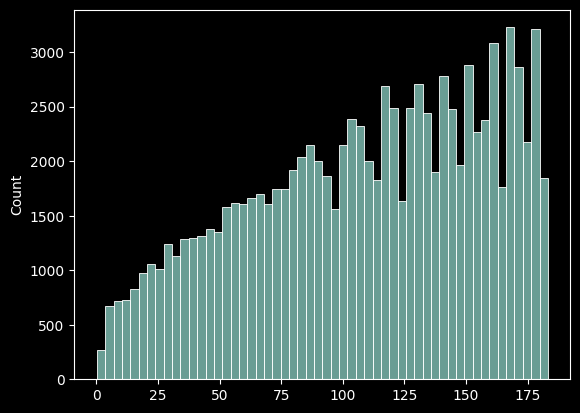

In [20]:
import seaborn as sns

index = cost_to_go.multinomial(num_samples=100_000, replacement=True)
sns.histplot(cost_to_go[index])

Here we set the `batch_size` to be 1000.
This means that 1000 systems will be simulated at once.

On every step, 1000 random states are taken from our sample, and best input is calculated for all of them.
Then, keeping inputs constant, we perform multiple steps of dynamics calculation.
This is needed to achieve greater precision of the simulation.

All of the described actions are performed under the hood in `CartPoleMultiSystem`.

In [21]:
from tqdm import tqdm

GAMMA = 0.99
EPOCHS = 2_500

for _ in tqdm(range(EPOCHS)):
    inputs = system.get_best_accelerations(context)
    new_states = system.eval_transitions(context, inputs)

    costs = input_cost_fn(inputs)

    ind = context.batch_indecies
    cost_to_go[ind] = cost_to_go[ind] * GAMMA + costs

    context.update_batch(batch_size=BATCH_SIZE)

torch.save(cost_to_go, "cost_to_go.torchobj")

100%|██████████| 2500/2500 [1:14:19<00:00,  1.78s/it]


<AxesSubplot: ylabel='Count'>

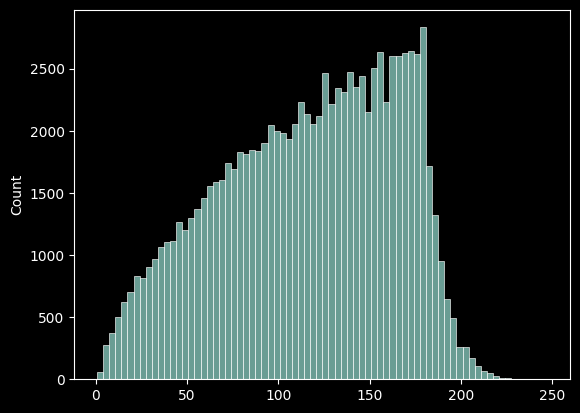

In [22]:
sns.histplot(cost_to_go[index])

---

In [23]:
from torch import nn


class MLP(nn.Module):
    def __init__(self) -> None:
        super(MLP, self).__init__()
        # Here we have 5 input features, even though our state consists
        # of 4 numbers. The explanation can be read in `forward` method.
        self.layers = nn.Sequential(
            nn.Linear(5, 32),  # input layer
            nn.Sigmoid(),
            nn.Linear(32, 100),  # hidden layer
            nn.Sigmoid(),
            nn.Linear(100, 1),  # output layer
        )
        self.double()

    def forward(self, x: DoubleTensor) -> DoubleTensor:
        # Here we transform our input data
        # To be precise, instead of `pole_angle` (x[1]) we will use 2 features:
        # `sin(pole_angle)` and `cos(pole_angle)` which allow us to fully determine
        # the angle and also get rid of any issues connected with angle jumping from
        # 2pi to 0 and back.
        # So introducing sin and cos will make our function smoother.
        x_transformed: DoubleTensor = torch.empty(
            size=(x.shape[0], 5),
            dtype=torch.double,
        )
        x_transformed[:, 0] = x[:, 0]
        x_transformed[:, 1] = torch.sin(x[:, 1])
        x_transformed[:, 2] = torch.cos(x[:, 1])
        x_transformed[:, 3] = x[:, 2]
        x_transformed[:, 4] = x[:, 3]

        return self.layers(x_transformed)

In [24]:
dataset = torch.hstack((context.discreditizer.all_states.mT, cost_to_go.reshape(-1, 1)))

dataset.shape

torch.Size([6615000, 5])

In [25]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from math import sqrt


trainloader = DataLoader(
    dataset=dataset,
    batch_size=420,
    shuffle=True,
)
loss_function = nn.MSELoss()

losses = []
tol = 1

model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 19):
    current_loss: float = 0

    for i, data in enumerate(tqdm(trainloader)):
        states: DoubleTensor = data[:, :4]
        costs: DoubleTensor = data[:, 4]
        optimizer.zero_grad()

        predicted_costs: DoubleTensor = model(states)
        loss = loss_function(predicted_costs, costs.reshape(-1, 1))

        loss.backward()
        optimizer.step()

        current_loss += loss.item()

    root_loss = sqrt(current_loss)

    print(f"Sqrt of average loss on epoch {epoch}: {float(root_loss)}")
    losses.append(float(root_loss))

    if len(losses) >= 2 and abs(losses[-1] - losses[-2]) < tol:
        print("Converged")
        break

100%|██████████| 15750/15750 [00:49<00:00, 319.79it/s]


Sqrt of average loss on epoch 1: 6799.795934578732


100%|██████████| 15750/15750 [00:47<00:00, 330.74it/s]


Sqrt of average loss on epoch 2: 1531.0178337862576


100%|██████████| 15750/15750 [00:45<00:00, 349.79it/s]


Sqrt of average loss on epoch 3: 1172.0641654072206


100%|██████████| 15750/15750 [00:45<00:00, 348.92it/s]


Sqrt of average loss on epoch 4: 1146.947962855188


100%|██████████| 15750/15750 [00:47<00:00, 330.71it/s]


Sqrt of average loss on epoch 5: 1134.0257333226602


100%|██████████| 15750/15750 [00:56<00:00, 277.06it/s]


Sqrt of average loss on epoch 6: 1126.984760048531


100%|██████████| 15750/15750 [00:44<00:00, 351.16it/s]


Sqrt of average loss on epoch 7: 1122.6214912152732


100%|██████████| 15750/15750 [00:44<00:00, 351.25it/s]


Sqrt of average loss on epoch 8: 1119.1789956463772


100%|██████████| 15750/15750 [00:45<00:00, 349.64it/s]


Sqrt of average loss on epoch 9: 1116.0480877641673


100%|██████████| 15750/15750 [00:44<00:00, 354.54it/s]


Sqrt of average loss on epoch 10: 1113.2602430680436


100%|██████████| 15750/15750 [00:44<00:00, 353.49it/s]


Sqrt of average loss on epoch 11: 1110.846040870475


100%|██████████| 15750/15750 [00:45<00:00, 343.09it/s]


Sqrt of average loss on epoch 12: 1108.738295948935


100%|██████████| 15750/15750 [00:44<00:00, 350.86it/s]


Sqrt of average loss on epoch 13: 1106.9827599425462


100%|██████████| 15750/15750 [00:48<00:00, 322.78it/s]


Sqrt of average loss on epoch 14: 1105.6425826932618


100%|██████████| 15750/15750 [00:47<00:00, 333.55it/s]


Sqrt of average loss on epoch 15: 1104.5784163594114


100%|██████████| 15750/15750 [00:47<00:00, 332.67it/s]

Sqrt of average loss on epoch 16: 1103.6400490073618
Converged


<AxesSubplot: >

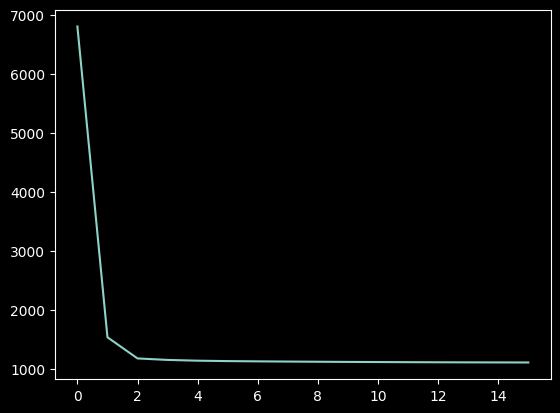

In [28]:
sns.lineplot(
    y=losses,
    x=range(len(losses)),
)

In [ ]:
example = State(
    0,
    3.05,
    0,
    0,
)


predicted_cost = float(model(example.as_tensor().reshape(1, -1)))
print("Predicted cost for", example, "is", predicted_cost)